# Cars Recognition
The goal of this project is to create a neural network capable of recognizing car brands from a photograph.

In [2]:
#check that the video card is connected
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-f6002671-54ca-a5f9-011f-b2870c7e032b)


Importing the required libraries

In [3]:
import os, re, math, random, time, gc, string, pickle, shutil, pathlib, itertools
import numpy as np, pandas as pd, matplotlib.pyplot as plt, PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import *
from tensorflow.keras.activations import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.layers import *
from tensorflow.keras.layers.experimental.preprocessing import *
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.optimizers.schedules import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from IPython.display import clear_output
from tqdm.notebook import tqdm

In [4]:
!gsutil cp gs://oleg-zyablov/skillfactory/sf-dl-car-classification.zip .
!unzip sf-dl-car-classification.zip
!unzip -q -o sf-dl-car-classification/train.zip
!unzip -q -o sf-dl-car-classification/test.zip
sample_submission_path = '/content/sf-dl-car-classification/sample-submission.csv'
train_path = '/content/train/'
sub_path = '/content/test_upload/'

Copying gs://oleg-zyablov/skillfactory/sf-dl-car-classification.zip...
/
Operation completed over 1 objects/1.6 GiB.                                      
Archive:  sf-dl-car-classification.zip
   creating: sf-dl-car-classification/
  inflating: sf-dl-car-classification/sample-submission.csv  
  inflating: sf-dl-car-classification/train.csv  
 extracting: sf-dl-car-classification/test.zip  
 extracting: sf-dl-car-classification/train.zip  


In [5]:
#class names
class_names = [
  'Приора', #0
  'Ford Focus', #1
  'Самара', #2
  'ВАЗ-2110', #3
  'Жигули', #4
  'Нива', #5
  'Калина', #6
  'ВАЗ-2109', #7
  'Volkswagen Passat', #8
  'ВАЗ-21099' #9
]

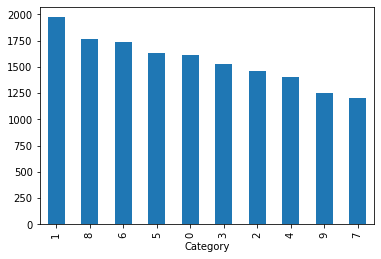

In [6]:
train_df = pd.read_csv("/content/sf-dl-car-classification/train.csv")
train_df.Category.value_counts().plot(kind = "bar", xlabel = "Category")

The diagram shows that our samples are well balanced.
Let's see what is shown in the pictures

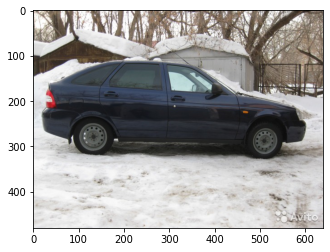

(640, 480)

In [7]:
image = PIL.Image.open(train_path+'/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

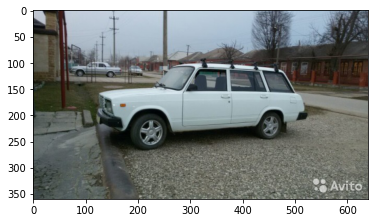

(640, 360)

In [8]:
image = PIL.Image.open(sub_path  +"/805.jpg")
imgplot = plt.imshow(image)
plt.show()
image.size

In [9]:
image_size = (90, 120)
batch_size = 32
RANDOM_SEED = 42
input_shape = (*image_size, 3)


# Creating Image Generators

In [10]:
train_datagen = ImageDataGenerator(
    #rescale=1/255,
    validation_split=0.2,
    # augmentation parameters:
    horizontal_flip=True,
    rotation_range=10,
    shear_range=0.2,
    brightness_range=(0.8, 1.2),
)

val_datagen = ImageDataGenerator(
    #rescale=1/255,
    validation_split=0.2,
)

sub_datagen = ImageDataGenerator(
    #rescale=1/255
)

Augmentation - a technique for increasing the amount of images by generating new data based on existing ones by distorting them

In [11]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=0,
    subset='training'
)

val_generator = val_datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=0,
    subset='validation'
)

sub_generator = sub_datagen.flow_from_dataframe( 
    dataframe=pd.read_csv(sample_submission_path),
    directory=sub_path,
    x_col="Id",
    y_col=None,
    class_mode=None,
    target_size=image_size,
    batch_size=batch_size,
    shuffle=False
)

Found 12452 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.
Found 6675 validated image filenames.


Train:


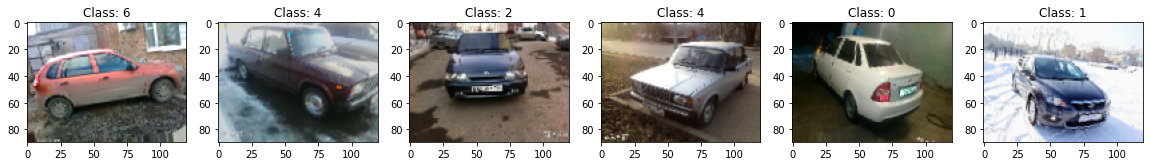

Val:


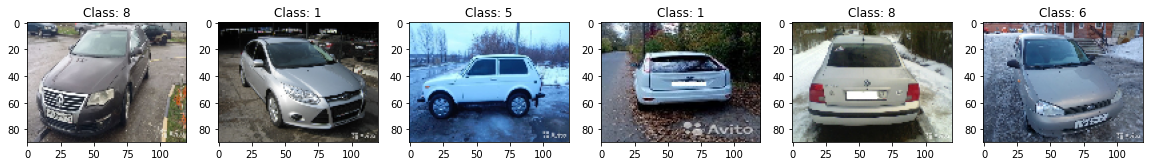

Sub:


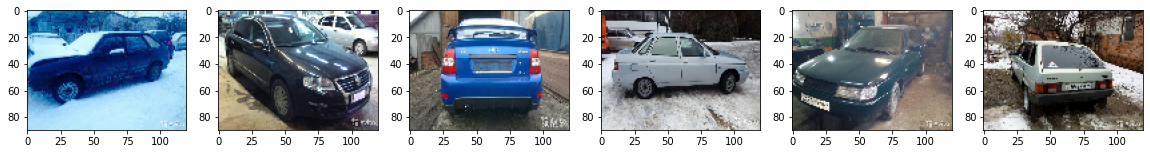

In [12]:
def show_first_images(generator, count=6, labels=True, figsize=(20, 5), normalized=False):
  generator = itertools.islice(generator, count)
  fig, axes = plt.subplots(nrows=1, ncols=count, figsize=figsize)
  for batch, ax in zip(generator, axes):
    if labels:
      img_batch, labels_batch = batch
      img, label = img_batch[0], np.argmax(labels_batch[0]) #берем по одному изображению из каждого батча
    else:
      img_batch = batch
      img = img_batch[0]
    if not normalized:
      img = img.astype(np.uint8)
    ax.imshow(img)
    # метод imshow принимает одно из двух:
    # - изображение в формате uint8, яркость от 0 до 255
    # - изображение в формате float, яркость от 0 до 1
    if labels:
      ax.set_title(f'Class: {label}')
  plt.show()

print('Train:')
show_first_images(train_generator)

print('Val:')
show_first_images(val_generator)

print('Sub:')
show_first_images(sub_generator, labels=False)

Let's create a convolutional neural network

In [13]:
model = Sequential()

# model layer 1
model.add(Convolution2D(128, (3, 3), input_shape=input_shape, activation='relu', padding='same',))
model.add(BatchNormalization())
# Pooling layer 1
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Convolution2D(128, (3, 3), activation='relu', padding='same',))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Convolution2D(256, (3, 3), activation='relu', padding='same',))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Convolution2D(256, (3, 3), activation='relu', padding='same',))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

# model and pooling layer 3.
model.add(Convolution2D(512, (3, 3), activation='relu', padding='same',))
model.add(BatchNormalization())
model.add(Convolution2D(512, (3, 3), activation='relu', padding='same',))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))


# Flattening
model.add(Flatten())

# Full connection
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 90, 120, 128)      3584      
                                                                 
 batch_normalization (BatchN  (None, 90, 120, 128)     512       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 45, 60, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 45, 60, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 60, 128)       147584    
                                                                 
 batch_normalization_1 (Batc  (None, 45, 60, 128)      5

In [15]:
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adamax(lr=0.0001), metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adamax.py:90: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adamax, self).__init__(name, **kwargs)


In [16]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = val_generator, 
        validation_steps = len(val_generator),
        epochs = 10
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
390/390 [==============================] - 154s 365ms/step - loss: 2.9532 - accuracy: 0.1249 - val_loss: 2.3165 - val_accuracy: 0.1499
Epoch 2/10
390/390 [==============================] - 136s 349ms/step - loss: 2.3915 - accuracy: 0.1348 - val_loss: 2.2849 - val_accuracy: 0.1499
Epoch 3/10
390/390 [==============================] - 136s 349ms/step - loss: 2.3141 - accuracy: 0.1419 - val_loss: 2.2660 - val_accuracy: 0.1673
Epoch 4/10
390/390 [==============================] - 136s 349ms/step - loss: 2.2794 - accuracy: 0.1526 - val_loss: 2.2576 - val_accuracy: 0.1721
Epoch 5/10
390/390 [==============================] - 136s 349ms/step - loss: 2.2723 - accuracy: 0.1542 - val_loss: 2.2452 - val_accuracy: 0.1775
Epoch 6/10
390/390 [==============================] - 136s 348ms/step - loss: 2.2462 - accuracy: 0.1633 - val_loss: 2.2118 - val_accuracy: 0.1785
Epoch 7/10
390/390 [==============================] - 135s 345ms/step - loss: 2.2303 - accuracy: 0.1669 - val_loss: 2.2037 -

In [17]:
scores = model.evaluate_generator(val_generator, steps=len(val_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


98/98 [==============================] - 18s 183ms/step - loss: 2.1582 - accuracy: 0.2161
Accuracy: 21.61%


In [18]:
def plot_history(history):
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    #plt.figure()
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()


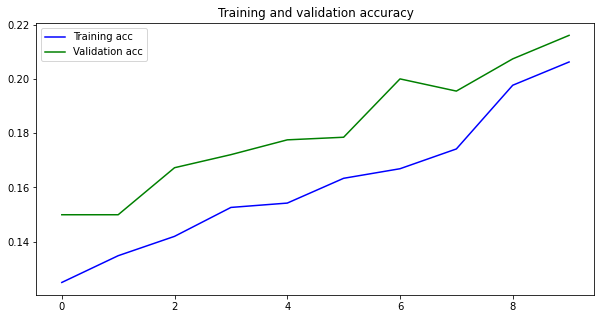

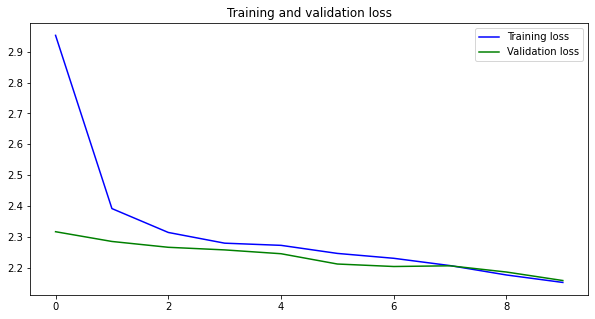

In [19]:
plot_history(history)

# Transfer Learning
# Step 1
Let's take the EfficientNetB0 model as a base model for the network and freeze it.



In [20]:
base_model_transfer= EfficientNetB7(weights='imagenet', include_top=False, input_shape=input_shape)
base_model_transfer.trainable = False

258088960/258076736 [==============================] - 2s 0us/step


Create a new model on top of the base model

In [21]:
def create_model():
  model=Sequential()
  model.add(base_model_transfer)
  model.add(GlobalAveragePooling2D(),)
  model.add(Dense(10, activation='softmax'))
  model.summary()
  return model

model_transfer = create_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional)  (None, 3, 4, 2560)       64097687  
                                                                 
 global_average_pooling2d (G  (None, 2560)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 10)                25610     
                                                                 
Total params: 64,123,297
Trainable params: 25,610
Non-trainable params: 64,097,687
_________________________________________________________________


In [22]:
print(len(model_transfer.layers))
print(len(model_transfer.trainable_variables))

3
2


check whether the base model is frozen

In [23]:
for layer in model_transfer.layers:
    print(layer, layer.trainable)

<keras.engine.functional.Functional object at 0x7f25a5068150> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f25a4fb7710> True
<keras.layers.core.dense.Dense object at 0x7f2530415e50> True


In [24]:
model_transfer.compile(loss=CategoricalCrossentropy(from_logits=True),
    optimizer=Adam(ExponentialDecay(1e-3, 100, 0.9)),
    metrics='accuracy')

In [25]:
scores = model_transfer.evaluate(val_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


98/98 [==============================] - 38s 267ms/step - loss: 2.3584 - accuracy: 0.0907
Accuracy: 9.07%


In [26]:
history = model_transfer.fit(
                    train_generator,
                    steps_per_epoch = train_generator.samples//train_generator.batch_size,
                    validation_data = val_generator, 
                    validation_steps = val_generator.samples//val_generator.batch_size,
                    epochs = 10
                    )

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


389/389 [==============================] - 189s 418ms/step - loss: 1.8786 - accuracy: 0.3304 - val_loss: 1.6820 - val_accuracy: 0.4143
Epoch 2/10
389/389 [==============================] - 161s 414ms/step - loss: 1.6452 - accuracy: 0.4229 - val_loss: 1.6138 - val_accuracy: 0.4220
Epoch 3/10
389/389 [==============================] - 161s 413ms/step - loss: 1.5624 - accuracy: 0.4675 - val_loss: 1.5533 - val_accuracy: 0.4694
Epoch 4/10
389/389 [==============================] - 162s 416ms/step - loss: 1.5304 - accuracy: 0.4758 - val_loss: 1.5316 - val_accuracy: 0.4684
Epoch 5/10
389/389 [==============================] - 161s 414ms/step - loss: 1.5090 - accuracy: 0.4860 - val_loss: 1.5144 - val_accuracy: 0.4878
Epoch 6/10
389/389 [==============================] - 161s 414ms/step - loss: 1.4912 - accuracy: 0.4913 - val_loss: 1.5091 - val_accuracy: 0.4865
Epoch 7/10
389/389 [==============================] - 162s 417ms/step - loss: 1.4897 - accuracy: 0.4914 - val_loss: 1.5023 - val_accura

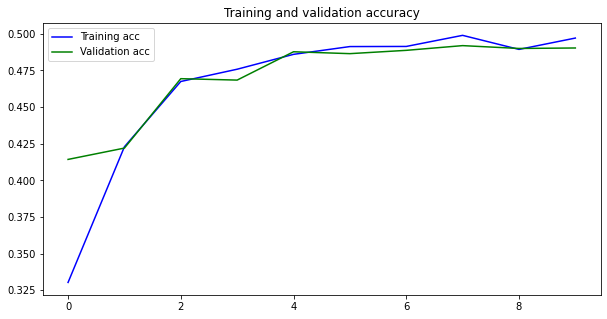

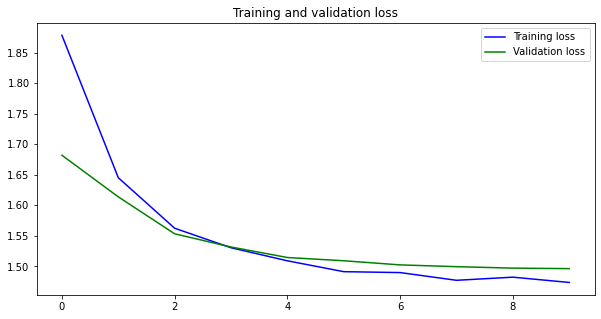

In [27]:
plot_history(history)

In [28]:
scores = model_transfer.evaluate(val_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

98/98 [==============================] - 25s 256ms/step - loss: 1.4961 - accuracy: 0.4905
Accuracy: 49.05%


# Step 2

In [29]:
model_transfer.trainable = True
# Fine-tune from this layer onwards
fine_tune_at = len(base_model_transfer.layers)//2

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model_transfer.layers[:fine_tune_at]:
  layer.trainable =  False

In [30]:
len(base_model_transfer.trainable_variables)

357

In [31]:
for layer in model_transfer.layers:
    print(layer, layer.trainable)

<keras.engine.functional.Functional object at 0x7f25a5068150> True
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f25a4fb7710> True
<keras.layers.core.dense.Dense object at 0x7f2530415e50> True


In [32]:
LR=0.0001
model_transfer.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=LR), metrics=["accuracy"])

In [33]:
model_transfer.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional)  (None, 3, 4, 2560)       64097687  
                                                                 
 global_average_pooling2d (G  (None, 2560)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 10)                25610     
                                                                 
Total params: 64,123,297
Trainable params: 59,262,562
Non-trainable params: 4,860,735
_________________________________________________________________


In [34]:
scores = model_transfer.evaluate(val_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

98/98 [==============================] - 35s 256ms/step - loss: 1.4961 - accuracy: 0.4905
Accuracy: 49.05%


In [35]:
history = model_transfer.fit(
                    train_generator,
                    steps_per_epoch = train_generator.samples//train_generator.batch_size,
                    validation_data = val_generator, 
                    validation_steps = val_generator.samples//val_generator.batch_size,
                    epochs = 15
                    )

Epoch 1/15
389/389 [==============================] - 283s 641ms/step - loss: 1.4261 - accuracy: 0.4845 - val_loss: 0.9330 - val_accuracy: 0.6646
Epoch 2/15
389/389 [==============================] - 248s 638ms/step - loss: 0.7444 - accuracy: 0.7315 - val_loss: 0.7395 - val_accuracy: 0.7419
Epoch 3/15
389/389 [==============================] - 249s 639ms/step - loss: 0.4653 - accuracy: 0.8365 - val_loss: 0.7161 - val_accuracy: 0.7610
Epoch 4/15
389/389 [==============================] - 248s 638ms/step - loss: 0.3260 - accuracy: 0.8841 - val_loss: 0.6795 - val_accuracy: 0.7761
Epoch 5/15
389/389 [==============================] - 249s 638ms/step - loss: 0.2315 - accuracy: 0.9194 - val_loss: 0.6985 - val_accuracy: 0.7848
Epoch 6/15
389/389 [==============================] - 249s 639ms/step - loss: 0.1839 - accuracy: 0.9358 - val_loss: 0.7305 - val_accuracy: 0.7893
Epoch 7/15
389/389 [==============================] - 248s 638ms/step - loss: 0.1428 - accuracy: 0.9535 - val_loss: 0.7173 -

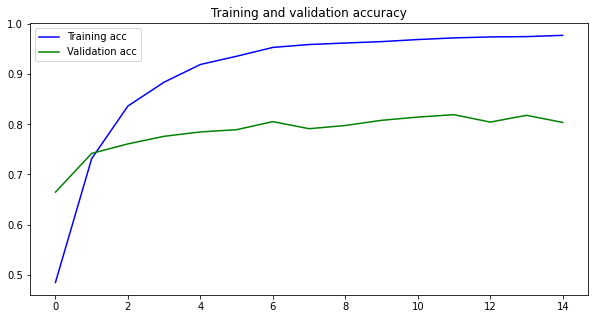

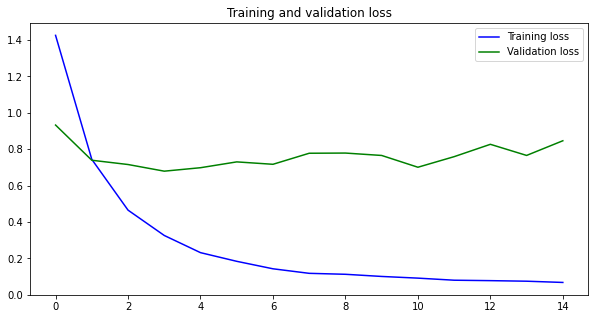

In [36]:
plot_history(history)

In [37]:
model_transfer.save("/content/step2_model.hdf5")

# Step 3

In [38]:
base_model_transfer.trainable = True

In [39]:
model_transfer.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=0.00001), metrics=["accuracy"])

In [40]:
checkpoint_path = "/content/best_model.hdf5"

checkpoint_dir = os.path.dirname(checkpoint_path)
# Create a callback that saves the model's weights
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                # monitor = ['val_accuracy'],
                                                 save_weights_only=True,
                                                 verbose=1)
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

In [41]:
os.listdir(checkpoint_dir)

['.config',
 'train',
 'sf-dl-car-classification',
 'sf-dl-car-classification.zip',
 'step2_model.hdf5',
 'test_upload',
 'sample_data']

In [ ]:
history = model_transfer.fit(
                    train_generator,
                    steps_per_epoch = train_generator.samples//train_generator.batch_size,
                    validation_data = val_generator, 
                    validation_steps = val_generator.samples//val_generator.batch_size,
                    epochs = 10,
                    callbacks=callbacks_list
                    )

Epoch 1/10
389/389 [==============================] - ETA: 0s - loss: 0.2680 - accuracy: 0.9170
Epoch 1: saving model to /content/best_model.hdf5
389/389 [==============================] - 456s 1s/step - loss: 0.2680 - accuracy: 0.9170 - val_loss: 0.8790 - val_accuracy: 0.7941
Epoch 2/10
389/389 [==============================] - ETA: 0s - loss: 0.1535 - accuracy: 0.9485
Epoch 2: saving model to /content/best_model.hdf5
389/389 [==============================] - 410s 1s/step - loss: 0.1535 - accuracy: 0.9485 - val_loss: 0.8114 - val_accuracy: 0.8006
Epoch 3/10
389/389 [==============================] - ETA: 0s - loss: 0.1097 - accuracy: 0.9619
Epoch 3: saving model to /content/best_model.hdf5
389/389 [==============================] - 410s 1s/step - loss: 0.1097 - accuracy: 0.9619 - val_loss: 0.7750 - val_accuracy: 0.8077
Epoch 4/10
389/389 [==============================] - ETA: 0s - loss: 0.0939 - accuracy: 0.9704
Epoch 4: saving model to /content/best_model.hdf5
389/389 [===========

In [ ]:
model_transfer.save("/content/step3_model.hdf5")

In [ ]:
os.listdir(checkpoint_dir)

In [ ]:
plot_history(history)

In [ ]:
model_transfer.save("/content/last_model.hdf5")

In [ ]:
best_transfer_model = create_model()

In [ ]:
best_transfer_model.load_weights("/content/best_model.hdf5")


In [ ]:
best_transfer_model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=0.00001), metrics=["accuracy"])

In [ ]:
scores = best_transfer_model.evaluate_generator(val_generator, verbose = 1)
scores

In [ ]:
predictions = best_transfer_model.predict(sub_generator) 
predictions

In [ ]:
submission_path = "/content/submission.csv"

In [ ]:
len(sub_generator.filenames)

In [ ]:
len(predictions[0])

In [ ]:
submission = pd.DataFrame({
    'Id': sub_generator.filenames,
    'Category':  np.argmax(predictions, axis=-1)
}, columns=['Id', 'Category'])
submission.to_csv(submission_path, index=False)

In [ ]:
from google.colab import files
files.download(submission_path)